In [18]:
# Test in a notebook cell
from portfolio_env import DynamicFeatureEngineer, DynamicPortfolioEnv
print("✅ Import successful!")


✅ Import successful!


In [19]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import torch
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
warnings.filterwarnings('ignore')

from portfolio_env import DynamicFeatureEngineer, DynamicPortfolioEnv

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("PART 2: PAPER TRADING & BACKTESTING")
print("=" * 80)
print("✅ Libraries imported")
print("✅ Classes imported from portfolio_env.py")
print("=" * 80)


PART 2: PAPER TRADING & BACKTESTING
✅ Libraries imported
✅ Classes imported from portfolio_env.py


In [20]:
MODEL_DIR = "models"
MODEL_NAME = "ppo_dynamic_portfolio_padded"
CONFIG_PATH = os.path.join(MODEL_DIR, "training_config.json")

with open(CONFIG_PATH, "r") as f:
    CONFIG = json.load(f)

model_path = os.path.join(MODEL_DIR, MODEL_NAME)
model = PPO.load(model_path)

print("\n📦 MODEL LOADED")
print("=" * 80)
print(f"Model: {MODEL_NAME}")
print(f"Max Assets Supported: {CONFIG['max_assets']}")
print(f"Trained on {CONFIG['num_training_assets']} assets")
print("=" * 80)



📦 MODEL LOADED
Model: ppo_dynamic_portfolio_padded
Max Assets Supported: 100
Trained on 55 assets


In [28]:
USER_TICKERS = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META",
    "JPM", "BAC", "UNH", "JNJ", "WMT"
]

BACKTEST_START = datetime(2025, 1, 6)
BACKTEST_END = datetime(2025, 11, 20)
INITIAL_CAPITAL = 100000

print("\n🎯 BACKTEST CONFIGURATION")
print("=" * 80)
print(f"Portfolio Size: {len(USER_TICKERS)} assets")
print(f"Tickers: {', '.join(USER_TICKERS)}")
print(f"Period: {BACKTEST_START.date()} to {BACKTEST_END.date()}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,}")
print("=" * 80)



🎯 BACKTEST CONFIGURATION
Portfolio Size: 10 assets
Tickers: AAPL, MSFT, GOOGL, AMZN, META, JPM, BAC, UNH, JNJ, WMT
Period: 2025-01-06 to 2025-11-20
Initial Capital: $100,000


In [29]:
def fetch_data(tickers, start, end):
    lookback_start = start - timedelta(days=365)
    print(f"\n📊 Downloading data from {lookback_start.date()} to {end.date()}...")
    df = yf.download(tickers, start=lookback_start, end=end, 
                     group_by="column", auto_adjust=True, progress=True)
    if "Close" in df.columns.get_level_values(0):
        df = df["Close"]
    if isinstance(df, pd.Series):
        df = df.to_frame(name=tickers[0])
    df = df.fillna(method="ffill").dropna()
    print(f"✅ Data loaded: {len(df)} trading days")
    return df

test_data = fetch_data(USER_TICKERS, BACKTEST_START, BACKTEST_END)
test_data_full = test_data.copy()
test_data = test_data[(test_data.index >= BACKTEST_START) & (test_data.index <= BACKTEST_END)]

print(f"Backtest period: {len(test_data)} days")



📊 Downloading data from 2024-01-07 to 2025-11-20...


[*********************100%***********************]  10 of 10 completed

✅ Data loaded: 470 trading days
Backtest period: 220 days


In [30]:
print("\n🚀 RUNNING BACKTEST")
print("=" * 80)

env = DynamicPortfolioEnv(
    tickers=list(test_data_full.columns),
    data=test_data_full,
    initial_capital=INITIAL_CAPITAL,
    commission=0.001,
    max_position_size=0.15,
    min_position_size=0.01,
    max_assets=int(CONFIG["max_assets"])
)

obs, _ = env.reset()

history = {
    "portfolio_value": [INITIAL_CAPITAL],
    "date": [test_data_full.index[60]],
    "weights": [],
    "cash": [INITIAL_CAPITAL],
    "holdings_value": [0]
}

steps = 0
start_idx = np.where(test_data_full.index >= BACKTEST_START)[0][0]
end_idx = np.where(test_data_full.index <= BACKTEST_END)[0][-1]

print(f"Starting backtest from index {start_idx} to {end_idx}...")

for idx in range(start_idx, end_idx):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    history["portfolio_value"].append(info["portfolio_value"])
    history["date"].append(test_data_full.index[env.current_step])
    history["weights"].append(action[:len(USER_TICKERS)])
    history["cash"].append(env.cash)
    history["holdings_value"].append((env.holdings * test_data_full.iloc[env.current_step].values).sum())
    steps += 1
    if done:
        break

results = pd.DataFrame({
    "date": history["date"],
    "portfolio_value": history["portfolio_value"],
    "cash": history["cash"],
    "holdings_value": history["holdings_value"]
}).set_index("date")

print(f"✅ Completed {steps} steps")
print("=" * 80)
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(results['portfolio_value'].iloc[-1]/INITIAL_CAPITAL - 1)*100:.2f}%")



🚀 RUNNING BACKTEST
Starting backtest from index 250 to 469...
✅ Completed 219 steps
Final Portfolio Value: $110,109.25
Total Return: 10.11%


In [31]:
daily_returns = results['portfolio_value'].pct_change().dropna()

total_return = (results['portfolio_value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0
max_drawdown = ((results['portfolio_value'].cummax() - results['portfolio_value']) / results['portfolio_value'].cummax()).max() * 100
volatility = daily_returns.std() * np.sqrt(252) * 100
avg_daily_return = daily_returns.mean() * 100
winning_days = (daily_returns > 0).sum()
total_days = len(daily_returns)

print("\n📊 PERFORMANCE METRICS")
print("=" * 80)
print(f"Initial Capital:       ${INITIAL_CAPITAL:>12,}")
print(f"Final Value:           ${results['portfolio_value'].iloc[-1]:>12,.2f}")
print(f"Total Return:          {total_return:>12.2f}%")
print(f"Sharpe Ratio:          {sharpe_ratio:>12.2f}")
print(f"Max Drawdown:          {max_drawdown:>12.2f}%")
print(f"Annualized Volatility: {volatility:>12.2f}%")
print(f"Avg Daily Return:      {avg_daily_return:>12.4f}%")
print(f"Winning Days:          {winning_days:>12} / {total_days}")
print(f"Win Rate:              {(winning_days/total_days)*100:>12.2f}%")
print("=" * 80)



📊 PERFORMANCE METRICS
Initial Capital:       $     100,000
Final Value:           $  110,109.25
Total Return:                 10.11%
Sharpe Ratio:                  0.78
Max Drawdown:                 12.13%
Annualized Volatility:        15.81%
Avg Daily Return:            0.0489%
Winning Days:                   125 / 219
Win Rate:                     57.08%


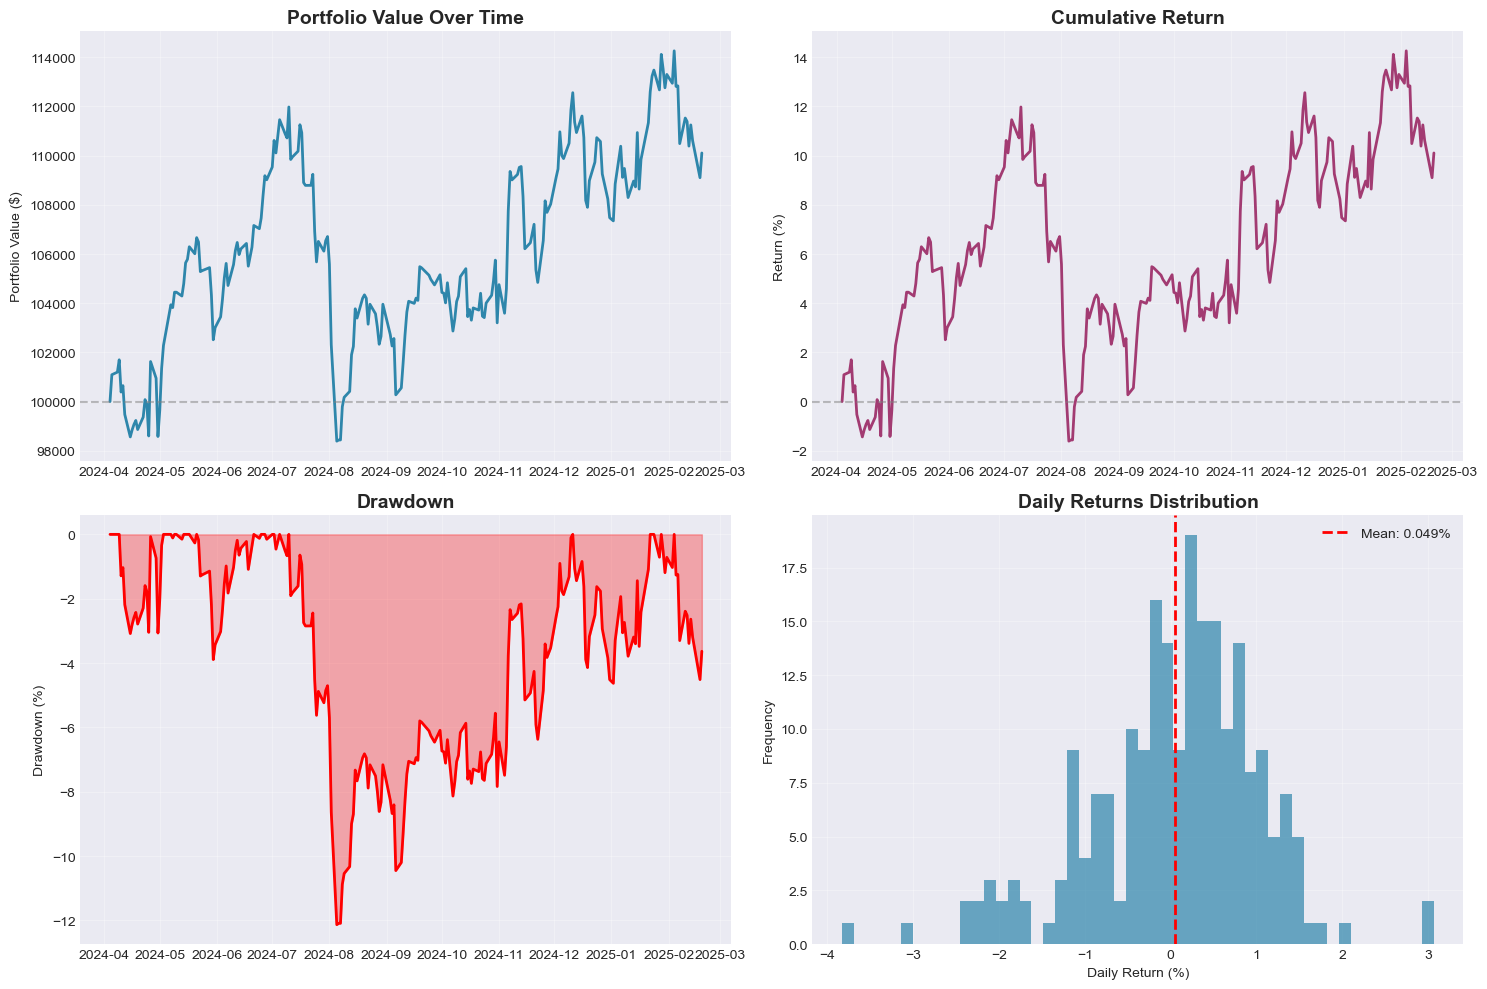

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Portfolio Value
ax1 = axes[0, 0]
ax1.plot(results.index, results['portfolio_value'], linewidth=2, color='#2E86AB')
ax1.axhline(INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True, alpha=0.3)

# 2. Cumulative Returns
ax2 = axes[0, 1]
cumulative_returns = ((results['portfolio_value'] / INITIAL_CAPITAL - 1) * 100)
ax2.plot(results.index, cumulative_returns, linewidth=2, color='#A23B72')
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Cumulative Return', fontsize=14, fontweight='bold')
ax2.set_ylabel('Return (%)')
ax2.grid(True, alpha=0.3)

# 3. Drawdown
ax3 = axes[1, 0]
drawdown = ((results['portfolio_value'].cummax() - results['portfolio_value']) / results['portfolio_value'].cummax()) * 100
ax3.fill_between(results.index, 0, -drawdown, alpha=0.3, color='red')
ax3.plot(results.index, -drawdown, linewidth=2, color='red')
ax3.set_title('Drawdown', fontsize=14, fontweight='bold')
ax3.set_ylabel('Drawdown (%)')
ax3.grid(True, alpha=0.3)

# 4. Daily Returns Distribution
ax4 = axes[1, 1]
ax4.hist(daily_returns * 100, bins=50, alpha=0.7, color='#2E86AB')
ax4.axvline(daily_returns.mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {daily_returns.mean()*100:.3f}%')
ax4.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Daily Return (%)')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


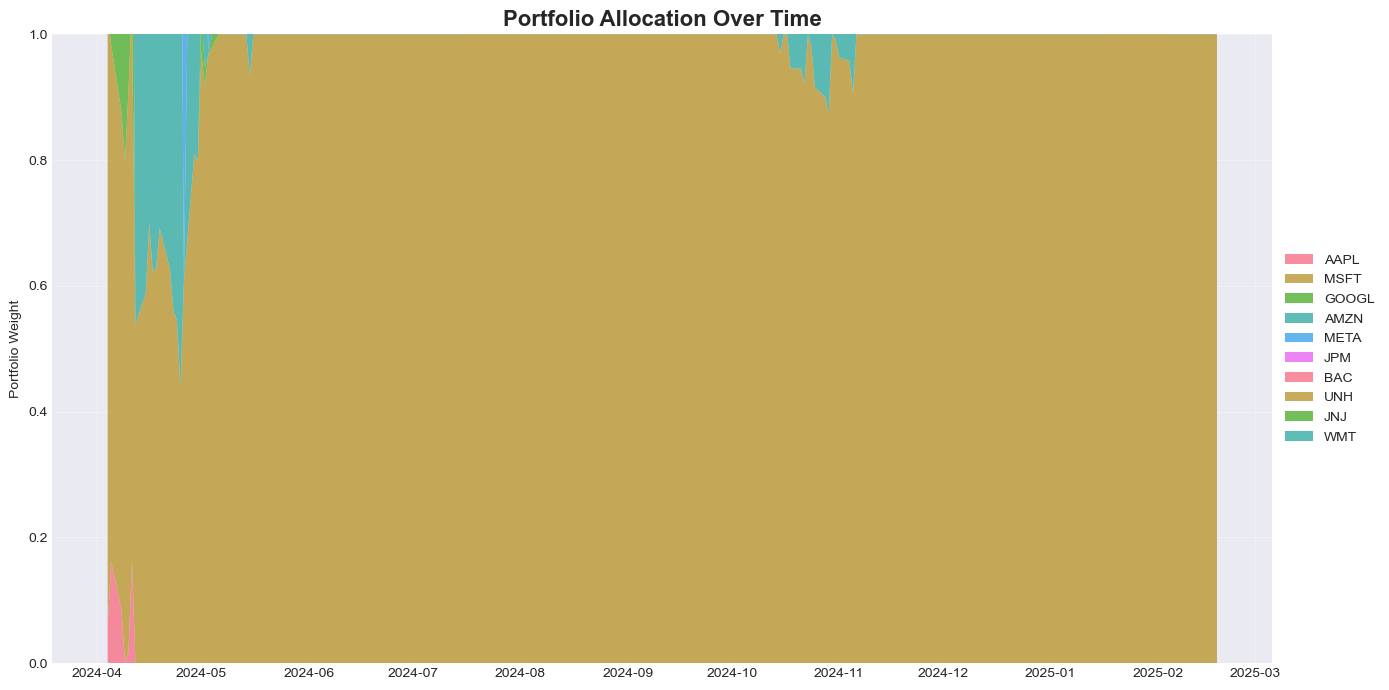


📈 AVERAGE PORTFOLIO WEIGHTS
  AAPL:   0.22%
  MSFT:  96.98%
 GOOGL:   5.73%
  AMZN:  70.53%
  META:   9.51%
   JPM:   0.04%
   BAC:   6.64%
   UNH:  73.04%
   JNJ:  88.04%
   WMT:   0.02%


In [33]:
weights = np.array(history["weights"])

if weights.shape[0] > 0:
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.stackplot(history["date"][:-1], 
                 *[weights[:, i] for i in range(len(USER_TICKERS))],
                 labels=USER_TICKERS,
                 alpha=0.8)
    ax.set_title('Portfolio Allocation Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Portfolio Weight')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    plt.tight_layout()
    plt.show()
    
    avg_weights = weights.mean(axis=0)
    print("\n📈 AVERAGE PORTFOLIO WEIGHTS")
    print("=" * 80)
    for ticker, weight in zip(USER_TICKERS, avg_weights):
        print(f"{ticker:>6}: {weight*100:>6.2f}%")
    print("=" * 80)


In [34]:
print("\n" + "=" * 80)
print("📋 BACKTEST SUMMARY REPORT")
print("=" * 80)
print(f"Portfolio: {', '.join(USER_TICKERS)}")
print(f"Period: {BACKTEST_START.date()} to {BACKTEST_END.date()}")
print(f"\n{'METRIC':<30} {'VALUE':>20}")
print("-" * 80)
print(f"{'Initial Capital':<30} ${INITIAL_CAPITAL:>19,}")
print(f"{'Final Portfolio Value':<30} ${results['portfolio_value'].iloc[-1]:>19,.2f}")
print(f"{'Total Profit/Loss':<30} ${results['portfolio_value'].iloc[-1] - INITIAL_CAPITAL:>19,.2f}")
print(f"{'Total Return':<30} {total_return:>19.2f}%")
print(f"{'Sharpe Ratio':<30} {sharpe_ratio:>20.2f}")
print(f"{'Max Drawdown':<30} {max_drawdown:>19.2f}%")
print(f"{'Annualized Volatility':<30} {volatility:>19.2f}%")
print(f"{'Win Rate':<30} {(winning_days/total_days)*100:>19.2f}%")
print("=" * 80)
print("\n✅ Backtest Complete!")



📋 BACKTEST SUMMARY REPORT
Portfolio: AAPL, MSFT, GOOGL, AMZN, META, JPM, BAC, UNH, JNJ, WMT
Period: 2025-01-06 to 2025-11-20

METRIC                                        VALUE
--------------------------------------------------------------------------------
Initial Capital                $            100,000
Final Portfolio Value          $         110,109.25
Total Profit/Loss              $          10,109.25
Total Return                                 10.11%
Sharpe Ratio                                   0.78
Max Drawdown                                 12.13%
Annualized Volatility                        15.81%
Win Rate                                     57.08%

✅ Backtest Complete!
